# MACD背离策略

In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 回测框架
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeed

# 基础函数
import utilsJ

## 策略

买入信号：MACD产生底部背离时买入。

买入仓位：满仓买入。

卖出信号：MACD产生顶部背离时卖出。

卖出仓位：一律平仓。

### 数据槽

In [2]:
class Data_MACD(btfeed.PandasData):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''
    lines = ('MA5','DIFF','DEA','MACD',
    )

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('MA5', -1),
        ('DIFF', -1), 
        ('DEA', -1),
        ('MACD', -1),
    )

### 策略主体

In [3]:
class MACD(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('stake', 100),
        ('allow_short', False),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.p.printlog or doprint:
            dt = dt or self.datas[0].datetime.datetime(0)
            print('%s: %s' % (dt.isoformat(sep=' '), txt))
            #with open('log.txt', 'a') as file:
            #    file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        
        # Initialization
        self.order = None
        self.buyprice = None
        self.sellprice = None
        self.ava_pos = 0
        self.buy_forzen = 0
        self.sell_forzen = 0
        
        # Alias
        self.dataclose = self.data.close
        self.datahigh = self.data.high
        self.datalow = self.data.low
        self.MACD = self.data.MACD
        self.MA5 = self.data.MA5

        # Indicators
        ## Plotting issue
        self.MACD_P = btind.MACDHisto(self.dataclose)
        self.MA5_P = btind.SMA(self.dataclose, period=5)
        self.macd_peak = bt.And(self.MACD < self.MACD(-1), 
                                self.MACD(-2) < self.MACD(-1))
        self.macd_peak_value = np.zeros(2)
        self.macd_bottom = bt.And(self.MACD > self.MACD(-1), 
                                  self.MACD(-2) > self.MACD(-1))
        self.macd_bottom_value = np.zeros(2)
        self.price_peak = bt.And(self.datahigh < self.datahigh(-1),
                                 self.datahigh(-2) < self.datahigh(-1))
        self.price_peak_value = np.zeros(2)
        self.price_bottom = bt.And(self.datalow > self.datalow(-1),
                                 self.datalow(-2) < self.datalow(-1))
        self.price_bottom_value = np.zeros(2)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Cash: %i' %
                         (order.executed.price, order.executed.size,
                          self.broker.get_cash()))
                self.buyprice = order.executed.price
                self.buy_forzen += order.executed.size

            else:
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cash: %i' %
                        (order.executed.price, -order.executed.size,
                         self.broker.get_cash()))
                self.sellprice = order.executed.price
                self.ava_pos += order.executed.size
                self.sell_forzen += order.executed.size
        
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):
        
        if self.order:
            return
        
        if self.data.datetime.time() == dt.time(9,30):
            self.ava_pos += self.buy_forzen
            self.buy_forzen = 0
            self.sell_forzen = 0
    
    
        # Record peak/bottom values
        if self.macd_peak[0]:
            if self.macd_peak_value[0] != 0:
                self.macd_peak_value[1] = self.macd_peak_value[0]
            self.macd_peak_value[0] = self.MACD[0]
        
        if self.macd_bottom[0]:
            if self.macd_bottom_value[0] != 0:
                self.macd_bottom_value[1] = self.macd_bottom_value[0]
            self.macd_bottom_value[0] = self.MACD[0]
        
        if self.price_peak[0]:
            if self.price_peak_value[0] != 0:
                self.price_peak_value[1] = self.price_peak_value[0]
            self.price_peak_value[0] = self.datahigh[0]
        
        if self.price_bottom[0]:
            if self.price_bottom_value[0] != 0:
                self.price_bottom_value[1] = self.price_bottom_value[0]
            self.price_bottom_value[0] = self.datalow[0]
        
        # Signals
        buy_s = self.price_bottom_value[0] < self.price_bottom_value[1] and \
                self.macd_bottom_value[0] > self.macd_bottom_value[1] and \
                self.macd_peak_value[0] > self.macd_peak_value[1]
                    
        
        sell_s = self.price_peak_value[0] > self.price_peak_value[1] and \
                self.macd_peak_value[0] < self.macd_peak_value[1] and \
                self.macd_bottom_value[0] < self.macd_bottom_value[1]
        
        ava_pos = self.broker.get_cash() // (self.dataclose[0] * self.p.stake) * self.p.stake

        if buy_s and self.dataclose[0] > self.MA5[0]:
            if self.ava_pos == 0 and self.buy_forzen == 0: # Open position
                self.log('BUY CREATE, Price: %.2f, Lots: %i' %
                         (self.dataclose[0], ava_pos))
                self.order = self.buy(size=ava_pos)
            elif self.ava_pos < 0: # Close position
                self.log('BUY CREATE (Close), Price: %.2f, Lots: %i' %
                         (self.dataclose[0], -self.free_pos))
                self.order = self.sell(size=self.free_pos)

        elif sell_s:
            if self.ava_pos == 0 and self.buy_forzen == 0 and self.p.allow_short: # Open position
                self.log('SELL CREATE, Price: %.2f, Lots: %i' %
                         (self.dataclose[0], ava_pos))
                self.order = self.buy(size=-ava_pos)
            elif self.ava_pos > 0: # Close position
                self.log('SELL CREATE (Close), Price: %.2f, Lots: %i' %
                         (self.dataclose[0], self.ava_pos))
                self.order = self.sell(size=self.ava_pos)
        

## 回测

### 单股测试

In [5]:
stock_code = '002791.SZ'
startdate = dt.datetime(2020,1,1) - dt.timedelta(days=20)
enddate = dt.datetime(2021,12,30)


if __name__ ==  '__main__':
    # Initialization
    cerebro = bt.Cerebro()
    strats = cerebro.addstrategy(MACD, printlog=True) 

    # Data
    df = utilsJ.get_stock(stock_code, startdate, enddate, path='.\\Data\\17-21_30min\\')
    data = Data_MACD(dataname=df,fromdate=startdate,todate=enddate)
    cerebro.adddata(data)

    # Start condition
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(10000)
    #cerebro.broker.setcommission()
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Execution
    cerebro.run()

    # Final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(iplot=False)

Starting Portfolio Value: 10000.00
2019-12-23 10:00:00: BUY CREATE, Price: 28.40, Lots: 300
2019-12-23 10:30:00: BUY EXECUTED, Price: 28.40, Lot:300, Cash: 1480
2020-01-03 14:30:00: SELL CREATE (Close), Price: 34.99, Lots: 300
2020-01-03 15:00:00: SELL EXECUTED, Price: 34.99, Lot:300, Cash: 11978
2020-01-03 15:00:00: OPERATION PROFIT, GROSS 1978.35, NET 1978.35
2020-01-10 09:30:00: BUY CREATE, Price: 37.04, Lots: 300
2020-01-10 10:00:00: BUY EXECUTED, Price: 37.04, Lot:300, Cash: 865
2020-01-15 10:00:00: SELL CREATE (Close), Price: 37.46, Lots: 300
2020-01-15 10:30:00: SELL EXECUTED, Price: 37.46, Lot:300, Cash: 12104
2020-01-15 10:30:00: OPERATION PROFIT, GROSS 125.85, NET 125.85
2020-02-07 14:30:00: BUY CREATE, Price: 39.21, Lots: 300
2020-02-07 15:00:00: BUY EXECUTED, Price: 39.21, Lot:300, Cash: 341
2020-02-13 09:30:00: SELL CREATE (Close), Price: 47.23, Lots: 300
2020-02-13 10:00:00: SELL EXECUTED, Price: 47.23, Lot:300, Cash: 14510
2020-02-13 10:00:00: OPERATION PROFIT, GROSS 240

### 沪深300成分测试

In [ ]:
index_code = '399300.SZ'
startdate = dt.datetime(2020,1,1) - dt.timedelta(days=20)
enddate = dt.datetime(2020,12,31)

if __name__ == '__main__':

    index_list = utilsJ.get_index_components(index_code, startdate, enddate)
    profit_stk = dict()
    for stk in index_list:
        # Initialization
        
        cerebro = bt.Cerebro()
        strats = cerebro.addstrategy(MACD) 

        # Data
        df = utilsJ.get_stock(stk, startdate, enddate, path='.\\Data\\17-21_30min\\')
        data = Data_MACD(dataname=df,fromdate=startdate,todate=enddate)
        cerebro.adddata(data)

        # Start condition
        cerebro.broker = bt.brokers.BackBroker(coc=True)   
        cerebro.broker.setcash(1000000)
        #cerebro.broker.setcommission()
        start_value = cerebro.broker.getvalue()
        #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Execution
        cerebro.run()

        # Final result
        final_value = cerebro.broker.getvalue()
        #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('%s, Net Profit: %.2f%%' % (stk,(final_value - start_value) / start_value * 100))
        profit_stk[stk] = (final_value - start_value) / start_value * 100

In [41]:
np.mean([float(x) for x in profit_stk.values()])

8.622839181556195

In [ ]:
sorted(profit_stk.items(), key=lambda x: x[1], reverse=True)

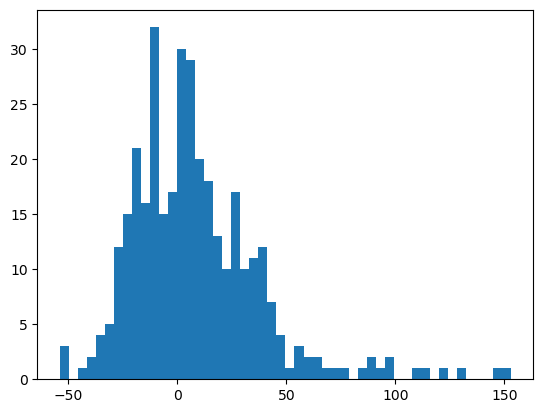

In [47]:
%matplotlib inline
plt.hist([float(x) for x in profit_stk.values()], bins=50)
plt.show()

### 全市场测试

In [4]:
startdate = dt.datetime(2020,1,1) - dt.timedelta(days=20)
enddate = dt.datetime(2021,12,30)

if __name__ == '__main__':

    index_list = utilsJ.get_stock_list()
    profit_stk = dict()
    for stk in index_list:
        try:
            # Initialization
            cerebro = bt.Cerebro()
            strats = cerebro.addstrategy(MACD) 

            # Data
            df = utilsJ.get_stock(stk, startdate, enddate, path='.\\Data\\17-21_30min\\')
            data = Data_MACD(dataname=df,fromdate=startdate,todate=enddate)
            cerebro.adddata(data)

            # Start condition
            cerebro.broker = bt.brokers.BackBroker(coc=True)   
            cerebro.broker.setcash(1000000)
            #cerebro.broker.setcommission()
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Execution
            cerebro.run()

            # Final result
            final_value = cerebro.broker.getvalue()
            #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            print('%s, Net Profit: %.2f%%' % (stk,(final_value - start_value) / start_value * 100))
            profit_stk[stk] = (final_value - start_value) / start_value * 100
        except:
            print('Failed. ' + stk)

000001.SZ, Net Profit: 10.79%
000002.SZ, Net Profit: -13.14%
000004.SZ, Net Profit: -17.40%
000005.SZ, Net Profit: 13.56%
000006.SZ, Net Profit: -25.91%
000007.SZ, Net Profit: 54.31%
000008.SZ, Net Profit: 2.72%
000009.SZ, Net Profit: 60.14%
000010.SZ, Net Profit: 50.29%
000011.SZ, Net Profit: -19.80%
000012.SZ, Net Profit: 23.59%
000014.SZ, Net Profit: 48.39%
000016.SZ, Net Profit: -3.33%
000017.SZ, Net Profit: 34.44%
000019.SZ, Net Profit: 50.37%
000020.SZ, Net Profit: -9.22%
000021.SZ, Net Profit: 35.10%
000023.SZ, Net Profit: 7.49%
000025.SZ, Net Profit: -24.82%
000026.SZ, Net Profit: 4.38%
000027.SZ, Net Profit: 22.07%
000028.SZ, Net Profit: -21.40%
000029.SZ, Net Profit: -3.97%
000030.SZ, Net Profit: -37.24%
000031.SZ, Net Profit: -41.12%
000032.SZ, Net Profit: 5.99%
000034.SZ, Net Profit: 77.22%
000035.SZ, Net Profit: -54.97%
000036.SZ, Net Profit: 42.80%
000037.SZ, Net Profit: 3.26%
000038.SZ, Net Profit: -26.03%
000039.SZ, Net Profit: 12.81%
000040.SZ, Net Profit: -53.63%
0000

In [5]:
np.mean([float(x) for x in profit_stk.values()])

5.975111328005901

In [6]:
sorted(profit_stk.items(), key=lambda x: x[1], reverse=True)

[('002791.SZ', 366.26350699999995),
 ('300763.SZ', 358.70396199999993),
 ('603069.SH', 272.67297099999996),
 ('688268.SH', 224.37778399999985),
 ('002151.SZ', 212.25119999999995),
 ('300767.SZ', 188.442761),
 ('600127.SH', 177.74450000000007),
 ('603010.SH', 176.965408),
 ('601908.SH', 176.73460000000014),
 ('603131.SH', 176.64776000000003),
 ('300243.SZ', 174.02147700000006),
 ('002245.SZ', 172.13944499999994),
 ('300318.SZ', 155.40710000000004),
 ('688333.SH', 154.66663599999995),
 ('002385.SZ', 154.12679100000005),
 ('688036.SH', 152.96625600000004),
 ('603959.SH', 152.6234000000001),
 ('002612.SZ', 148.7149740000001),
 ('300019.SZ', 148.45973200000006),
 ('002371.SZ', 145.2635609999999),
 ('000698.SZ', 141.6764),
 ('688126.SH', 140.40499999999986),
 ('300716.SZ', 138.05589500000002),
 ('002240.SZ', 137.6605000000001),
 ('600359.SH', 134.46020000000001),
 ('688019.SH', 133.528767),
 ('002594.SZ', 132.0741420000001),
 ('603880.SH', 130.37350200000014),
 ('300099.SZ', 127.056569000000

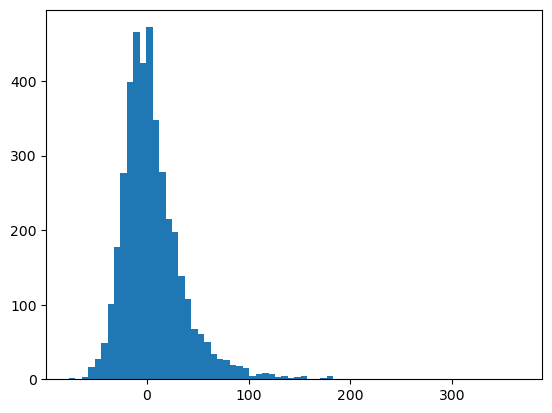

In [8]:
%matplotlib inline
plt.hist([float(x) for x in profit_stk.values()], bins=70)
plt.show()